In [1]:
import glob
import scipy
import os,sys
import zipfile
import numpy as np
import nibabel as nib
import tensorflow as tf
from scipy import ndimage
from tensorflow import keras
from natsort import natsorted
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from aifnet_utils.preprocess import read_nifti_file, normalize, normalize_aif, process_scan, normalize_zero_one
from aifnet_utils.data_loaders import read_isles_volumepaths_from_file_otf, read_isles_annotations_from_file, ISLES18DataGen_aifvof_otf
from aifnet_utils.data_loaders import delay_sequence_padding, anticipate_sequence_padding, late_bolus, early_bolus
from aifnet_utils.results import plot_predictions
from aifnet_utils.losses import MaxCorrelation
from scipy import signal
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from scipy.linalg import convolution_matrix, toeplitz, circulant
from sklearn.linear_model import Ridge
from matplotlib import pyplot, image, transforms
from scipy import ndimage
from numpy import inf
import random

%matplotlib inline

!pwd

/home/sebastian/experiments/aifnet_replication


In [2]:
#Reading an example PCT volume

In [3]:

keras.backend.set_image_data_format('channels_last')
ROOT_EXP = '/home/sebastian/experiments/aifnet_replication/'
root_dir     = '/media/sebastian/data/ASAP/ISLES2018_Training'
current_fold = 3
#At insel: /media/sebastian/data/ASAP/ISLES2018_Training
#Local: '/Users/sebastianotalora/work/postdoc/data/ISLES/'
aif_annotations_path = ROOT_EXP + 'annotated_aif_vof_complete_revised.csv'
min_num_volumes_ctp = 43

#Reading AIFs and VOFs for each of the partitions
train_partition_path = ROOT_EXP+'/partitions/fold_'+str(current_fold) +'/train.txt'
valid_partition_path = ROOT_EXP+'/partitions/fold_'+str(current_fold) +'/valid.txt'
test_partition_path =  ROOT_EXP+'/partitions/fold_'+str(current_fold) +'/test.txt'

aif_annotations_train, vof_annotations_train = read_isles_annotations_from_file(aif_annotations_path, train_partition_path, 
                                                root_dir, min_num_volumes_ctp, return_aif_only = False)
aif_annotations_valid, vof_annotations_valid = read_isles_annotations_from_file(aif_annotations_path, valid_partition_path, root_dir, 
                                        min_num_volumes_ctp, return_aif_only = False)
aif_annotations_test, vof_annotations_test = read_isles_annotations_from_file(aif_annotations_path,  test_partition_path,
                                        root_dir, min_num_volumes_ctp, return_aif_only = False)

ctp_volumes_train = read_isles_volumepaths_from_file_otf(root_dir, train_partition_path, aif_annotations_path)
ctp_volumes_valid = read_isles_volumepaths_from_file_otf(root_dir, valid_partition_path, aif_annotations_path)
ctp_volumes_test = read_isles_volumepaths_from_file_otf(root_dir, test_partition_path, aif_annotations_path)

print(len(ctp_volumes_train), len(aif_annotations_train))
print(len(ctp_volumes_valid), len(aif_annotations_valid))
print(len(ctp_volumes_test), len(aif_annotations_test))



67 67
7 7
20 20


In [4]:
train_datagen = ISLES18DataGen_aifvof_otf(ctp_volumes=ctp_volumes_train, annotations_aif=aif_annotations_train,
                                          annotations_vof=vof_annotations_train,minimum_number_volumes_ctp = 43, 
                                          batch_size=1,time_arrival_augmentation = True, delay_t=0,
                                          scale_aif = False, normalize_hu=False)


In [5]:
example_id = 36
sample_pct = train_datagen.__getitem__(example_id)
pct_vals = sample_pct[0][0,:,:,:,:]
vascular_functions = sample_pct[1]
aif = vascular_functions[0]
vof = vascular_functions[1]

In [6]:
path_case = '/'.join(train_datagen.ctp_volumes[example_id]['image'].split('/')[0:-2])
path_cbf = glob.glob(path_case+"/*CBF*/*nii")[0]
path_cbf

'/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_48/SMIR.Brain.XX.O.CT_CBF.345880/SMIR.Brain.XX.O.CT_CBF.345880.nii'

In [83]:
pct_vals.shape

(256, 256, 2, 43)

In [86]:
voi

array([-23.        , -23.        , -23.        , -23.        ,
       -23.        , -23.        , -23.        , -23.00000191,
       -23.        , -23.        , -23.        , -23.        ,
       -23.        , -23.        , -23.        , -23.        ,
       -23.        , -23.        , -23.        , -23.        ,
       -23.        , -23.        , -23.        , -23.        ,
       -23.        , -23.        , -23.        , -23.        ,
       -23.        , -23.        , -23.        , -23.        ,
       -23.        , -23.        , -23.        , -23.        ,
       -23.        , -23.        , -23.        , -23.        ,
       -23.        , -23.        , -23.        ])

In [96]:
bolus_arrival_time = 10
baseline_mu = np.mean(aif[0:bolus_arrival_time])
print(baseline_mu)

37.75536842346192


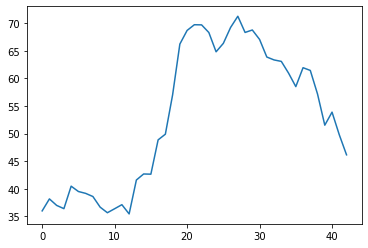

In [95]:
plt.plot(aif)

In [8]:
train_datagen.ctp_volumes

[{'image': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_1/SMIR.Brain.XX.O.CT_4DPWI.345561/SMIR.Brain.XX.O.CT_4DPWI.345561.nii'},
 {'image': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_2/SMIR.Brain.XX.O.CT_4DPWI.345568/SMIR.Brain.XX.O.CT_4DPWI.345568.nii'},
 {'image': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_3/SMIR.Brain.XX.O.CT_4DPWI.345575/SMIR.Brain.XX.O.CT_4DPWI.345575.nii'},
 {'image': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_4/SMIR.Brain.XX.O.CT_4DPWI.345582/SMIR.Brain.XX.O.CT_4DPWI.345582.nii'},
 {'image': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_5/SMIR.Brain.XX.O.CT_4DPWI.345589/SMIR.Brain.XX.O.CT_4DPWI.345589.nii'},
 {'image': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_6/SMIR.Brain.XX.O.CT_4DPWI.345596/SMIR.Brain.XX.O.CT_4DPWI.345596.nii'},
 {'image': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_7/SMIR.Brain.XX.O.CT_4DPWI.345603/SMIR.Brain.XX.O.CT_4DPWI

In [9]:
np.mean(pct_vals[:,:])

75.2385706456608

In [10]:
mu_voi = np.array([np.mean(pct_vals[:,:,:,i]) for i in range(pct_vals.shape[-1])])
print(mu_voi)
mu_voi.shape

[74.45011817 74.34831101 74.29299524 74.27400769 74.28124857 74.23902928
 74.26885718 74.30141403 74.25310225 74.32000191 74.35243032 74.38162614
 74.45736887 74.52478625 74.66185092 74.87797194 75.18482974 75.25364911
 75.41307753 75.59240533 75.61928935 75.76210867 75.79344014 75.78041724
 75.90560806 75.8791946  75.86668447 75.88348314 75.91791636 76.0171112
 76.05063522 76.00375041 75.8828254  75.88575978 75.81928028 75.69567829
 75.66248161 75.65151836 75.66306236 75.68931585 75.69943348 75.71325725
 75.68720475]


(43,)

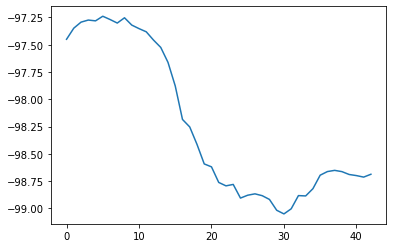

In [89]:
plt.plot(voi - mu_voi)

In [11]:
np.argmin(mu_voi)

5

Text(0, 0.5, 'Normalized Density (HU)')

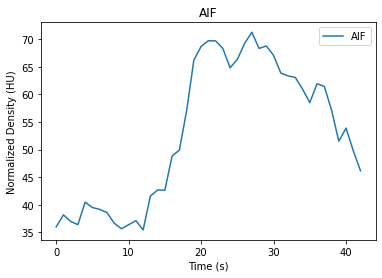

In [12]:
plt.title('AIF')        
#y = normalize_zero_one(aif)
#y_p = normalize_zero_one(vof)
#plt.plot(mu_voi)
#plt.plot(y_p)
plt.plot(aif)
plt.legend([ 'AIF'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')


In [13]:
np.argmax(np.abs(np.gradient(mu_voi)))

15

Text(0, 0.5, 'Normalized Density (HU)')

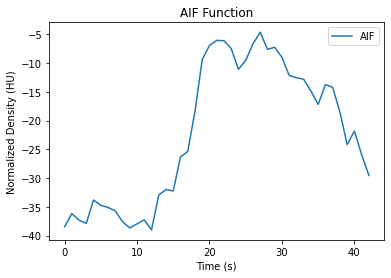

In [14]:
plt.title('AIF Function')        
y = normalize_zero_one(aif)
y_p = normalize_zero_one(vof)
plt.plot((aif)-(mu_voi))
#plt.plot(y_p)
#plt.plot(mu_voi)
plt.legend(['AIF','VOF', 'mu_VOI'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')


In [15]:
A = np.multiply(np.tril(np.ones((aif.shape[0],aif.shape[0]))), circulant(aif))

In [16]:
A

array([[35.98763275,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [38.15778351, 35.98763275,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [36.98163605, 38.15778351, 35.98763275, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [53.88126755, 51.52096176, 57.15507126, ..., 35.98763275,
         0.        ,  0.        ],
       [49.77805328, 53.88126755, 51.52096176, ..., 38.15778351,
        35.98763275,  0.        ],
       [46.14902496, 49.77805328, 53.88126755, ..., 36.98163605,
        38.15778351, 35.98763275]])

In [17]:
aif

array([35.98763275, 38.15778351, 36.98163605, 36.39125443, 40.46656799,
       39.49963379, 39.16095734, 38.59014893, 36.66381836, 35.6542511 ,
       36.37831116, 37.11220169, 35.43841553, 41.5814209 , 42.67570114,
       42.63991165, 48.85564423, 49.88788605, 57.01840591, 66.21945953,
       68.6887207 , 69.72374725, 69.69806671, 68.31298065, 64.81871033,
       66.34746552, 69.22781372, 71.26161957, 68.32446289, 68.77049255,
       67.06043243, 63.87047195, 63.3430481 , 63.08028793, 60.95465469,
       58.50625229, 61.93690491, 61.44015884, 57.15507126, 51.52096176,
       53.88126755, 49.77805328, 46.14902496])

In [18]:
u, s, vh = np.linalg.svd(A, full_matrices=True)

In [19]:
np.linalg.pinv(A)

array([[ 2.77873237e-02, -5.23994210e-17, -1.61371496e-17, ...,
         8.54653732e-18,  3.96431947e-18, -3.06274093e-18],
       [-2.94629738e-02,  2.77873237e-02,  1.53850465e-17, ...,
        -6.72761705e-18,  6.00018107e-18,  9.84710579e-18],
       [ 2.68484137e-03, -2.94629738e-02,  2.77873237e-02, ...,
        -2.27413656e-18, -8.86792098e-18,  6.84541062e-18],
       ...,
       [-5.56968755e-03, -3.33178742e-05,  1.49904954e-03, ...,
         2.77873237e-02,  2.93167044e-18,  1.37406306e-17],
       [ 3.04958823e-03, -5.56968755e-03, -3.33178742e-05, ...,
        -2.94629738e-02,  2.77873237e-02,  1.00840316e-17],
       [-1.92856053e-03,  3.04958823e-03, -5.56968755e-03, ...,
         2.68484137e-03, -2.94629738e-02,  2.77873237e-02]])

In [20]:
truncation_vals = 3
S = np.diag(1/s)
S[-truncation_vals:,-truncation_vals:] = 0

In [21]:
A_inv = np.matmul(np.matmul(u,S), vh)

In [22]:
A_inv.shape

(43, 43)

In [23]:
pseudo_inv = scipy.linalg.pinv2(A)

In [24]:
k =  np.matmul(mu_voi,A_inv)

In [25]:
T_max = np.argmax(k)
print(T_max)

0


In [26]:
clf = Ridge(alpha=1.0)
clf.fit(A, mu_voi)
k_tik = clf.predict(A)

Text(0, 0.5, 'Normalized Density (HU)')

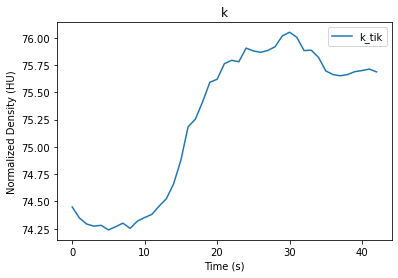

In [27]:
plt.title('k')        
#plt.plot(k)
plt.plot(k_tik)
#plt.plot(mu_voi)
plt.legend(['k_tik'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')

In [28]:
print(A.shape)
print(k_tik.shape)
print(k_tik.shape)
print(pct_vals.shape)
example_voi = pct_vals[100,100,0,:]
print(example_voi.shape)

(43, 43)
(43,)
(43,)
(256, 256, 2, 43)
(43,)


Text(0, 0.5, 'Normalized Density (HU)')

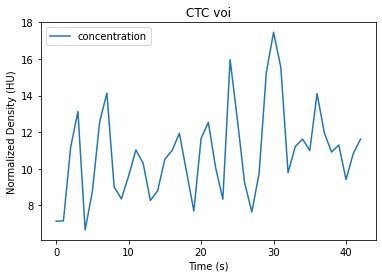

In [29]:
plt.title('CTC voi')        
#plt.plot(k)
plt.plot(example_voi)
#plt.plot(mu_voi)
plt.legend(['concentration'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')

Text(0, 0.5, 'Normalized Density (HU)')

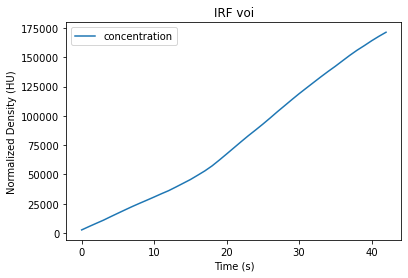

In [30]:
plt.title('IRF voi')        
#plt.plot(k)
plt.plot(np.matmul(A,k_tik))
#plt.plot(mu_voi)
plt.legend(['concentration'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')


In [31]:
1/example_voi

array([0.14018765, 0.13988284, 0.08944097, 0.07616297, 0.1502741 ,
       0.11401101, 0.07962536, 0.07075405, 0.11100363, 0.11975725,
       0.10408417, 0.09071082, 0.09705786, 0.1209708 , 0.11376285,
       0.09502319, 0.09090562, 0.08378127, 0.1019198 , 0.13004858,
       0.08576496, 0.07976518, 0.09934536, 0.11997794, 0.06263767,
       0.07869939, 0.10829306, 0.1309622 , 0.10272082, 0.06551762,
       0.05726219, 0.06431302, 0.1021837 , 0.08914696, 0.08606805,
       0.09091038, 0.07086871, 0.08351132, 0.09166312, 0.08851586,
       0.1062547 , 0.092341  , 0.08604959])

In [32]:
np.max(np.matmul(A,k_tik)/(1/example_voi))

2075422.906817207

Text(0, 0.5, 'Normalized Density (HU)')

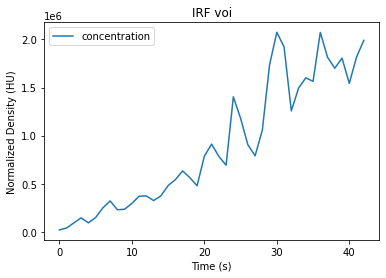

In [33]:
plt.title('IRF voi')        
#plt.plot(k)
plt.plot(np.matmul(A,k_tik)/(1/example_voi))
#plt.plot(mu_voi)
plt.legend(['concentration'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')


In [81]:
CBFs = np.zeros((pct_vals.shape[0],pct_vals.shape[1],pct_vals.shape[2]))
for cur_slice in range(CBFs.shape[2]):
    for i in range(CBFs.shape[0]):
        for j in range (CBFs.shape[1]):
            voi = pct_vals[i,j,cur_slice,:]
            CBFs[i,j,cur_slice]    = np.max(np.multiply(np.matmul(A_inv,k),voi))
            #CBFs[i,j,cur_slice], _ = signal.deconvolve(voi, k)

99.83556147608599


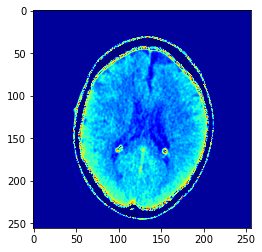

In [82]:
#tr = transforms.Affine2D().rotate_deg(50)
selected_slice = 0
img = CBFs[:,:,selected_slice]
print(np.max(img))
img[img > 40] = 0

#pp = img>0.005
#rotated_img = ndimage.rotate(, 45*60)
estimated_cbf = np.array(normalize_zero_one(img)*255,dtype = 'uint8')
rotated_img = ndimage.rotate(estimated_cbf, 90)

reflected_img = np.flip(rotated_img,axis=1)


plt.imshow(6*reflected_img,cmap=plt.cm.jet)
#plt.imshow(, transform=tr)

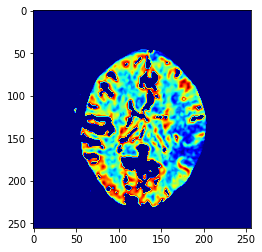

In [63]:
path_case = '/'.join(train_datagen.ctp_volumes[example_id]['image'].split('/')[0:-2])
path_cbf = glob.glob(path_case+"/*CBF*/*nii")[0]
path_cbf
gt_cbf = nib.load(path_cbf).get_fdata()
gt_cbf[gt_cbf >365] = 0
gt_img = np.array(normalize_zero_one(gt_cbf[:,:,selected_slice])*255,dtype = 'uint8')
rotated_img = ndimage.rotate(gt_img, 90)
reflected_img = np.flip(rotated_img,axis=1)

plt.imshow(reflected_img,cmap=plt.cm.jet)

In [134]:
path_cbf

'/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_38/SMIR.Brain.XX.O.CT_CBF.345810/SMIR.Brain.XX.O.CT_CBF.345810.nii'

In [707]:
np.max(gt_cbf[:,:,selected_slice])

0.0

In [784]:
np.max(gt_cbf[:,:,selected_slice])

4402.0

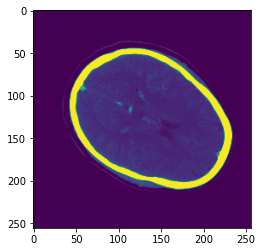

In [696]:
slice_7 = CBFs[:,:,7]
#slice_7[slice_7>1] = 0
rotated_img = ndimage.rotate(slice_7, 0)
plt.imshow(rotated_img)


In [ ]:
#%Calculate the CBF map
#cbfmap = scaling_factor * squeeze(max(rmap));


In [562]:
CBF = np.multiply(np.max(k_tik), 1/pct_vals)

In [563]:
pct_vals[pct_vals==0] = 0.000001

In [564]:
np.max(1/pct_vals[:,:,4])

1000000.0

In [565]:
CBF[CBF == inf] = 0

In [566]:
np.sum(CBF[:,:,0,:])

189016130000.0

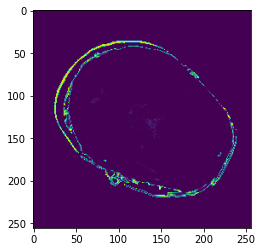

In [567]:
CBF_agregated = CBF.sum(axis=3)
normalized_CBF = normalize_zero_one(CBF_agregated)
normalized_CBF[normalized_CBF==1] = 0
normalized_CBF[normalized_CBF==0.28370348] = 0
plt.imshow(np.array(normalize_zero_one(normalized_CBF[:,:,1])*255, dtype='uint8'))

In [568]:
normalize_zero_one(CBF_agregated[:,:,5])

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [569]:
np.max(k_tik)

0.10646189112895685

Text(0, 0.5, 'Normalized Density (HU)')

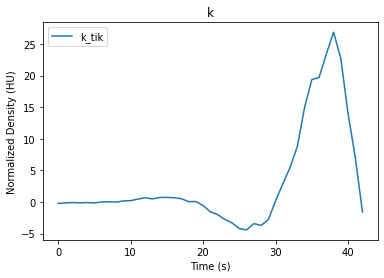

In [572]:
plt.title('k')        
plt.plot(-k)
#plt.plot(k_tik)
#plt.plot(mu_voi)
plt.legend(['k_tik'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')


Text(0, 0.5, 'Normalized Density (HU)')

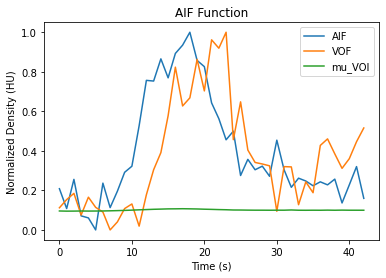

In [548]:
plt.title('AIF Function')        
y = normalize_zero_one(aif)
y_p = normalize_zero_one(vof)
plt.plot(y)
plt.plot(y_p)
plt.plot(mu_voi)
#plt.plot(k)
plt.legend(['AIF','VOF', 'mu_VOI', 'k'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')


In [279]:
near_I = np.matmul(A,A_inv.T)
#near_I = np.matmul(A,pseudo_inv)

In [280]:
np.allclose(np.eye(near_I.shape[0]),near_I)

True

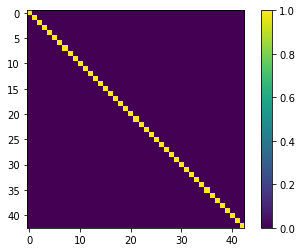

In [281]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(near_I)
plt.colorbar()
plt.show()

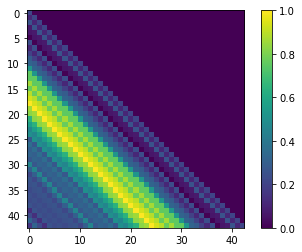

In [284]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(A)
plt.colorbar()
plt.show()